### Polynomial Regression 

This is really the same as linear regression example that the line we're fitting has terms that are powers of the independent variable.

A point of confusion for me was the declaration of $ A $. A linear model wouldn't have terms that are different powers of $ t $.

Notice that $ A $ doesn't take $ y $ as a parameter. Then if the curve changes as the data changes, that's because we've made the polynomial do that. The polynomial won't change to fit the data. The regression happens the same as linear regression in the sense that the y-intercept, and orientation, of the curve will changes as it would with a straight line.

In [1]:
clear;

t=[1:12 , 14:25]; % array with outlier t=13 missing
y = [12.1739, 15.8046, 19.1459, 21.0933, 24.2243, 24.3662, 28.6772, 31.0866, 35.9575, 35.4795, ...
     38.3172, 41.5313, 45.4348, 47.0831, 50.7045, 51.6634, 53.9006, 56.2827, 57.9554, 64.2971, ...
     67.3964, 66.0845, 68.5797, 68.7091];

%First model t - beta_1 + beta_2 t + beta_3 sqrt(t)*sin(t)

A = [ones(24,1), t', sqrt(t').*sin(t')]; 

beta = A\y';
residuals = A*beta - y';


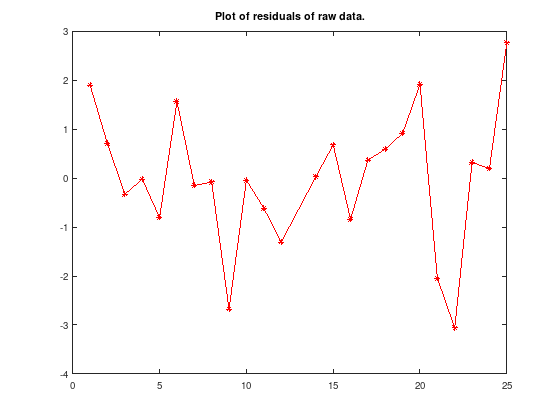

In [2]:
figure(1)
plot(t,residuals,'r*-');
title('Plot of residuals of raw data.')

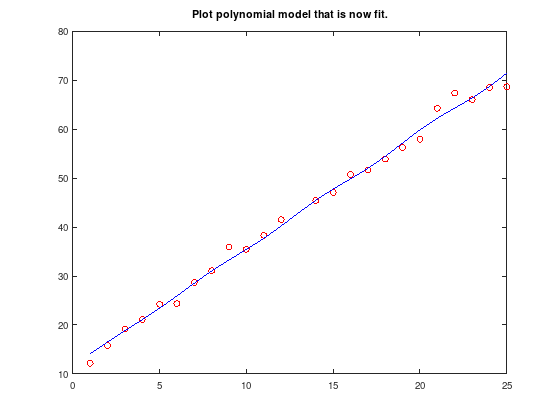

In [3]:
figure(2)
plot(t,y,'ro')
title('Plot polynomial model that is now fit.')
f = @(x) beta(1)+beta(2)*x + beta(3)*sqrt(x).*sin(x); % This is nonlinear and can't be expected to be a line
hold on;
u=1:0.01:25;
v=f(u);
plot(u,v,'b-');
hold off;

### Polynomial Regression - optimise PR with Nelder-Mead (fminsearch)

Note the non-linear model below has variables $ p, \theta $. If you vary those you will find that that just changes the shape of the curve.

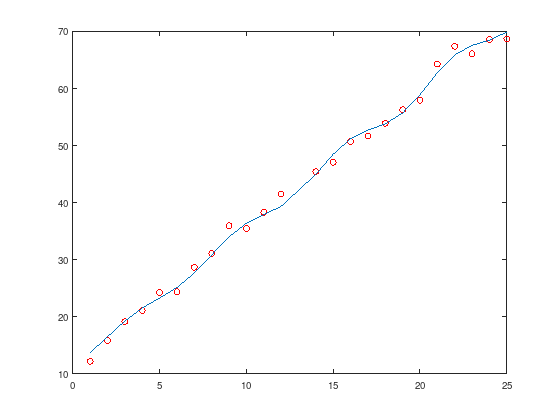

In [4]:
p = 1/2;
theta = 0;

A_new = [ones(length(t),1) t' (t').^p.*cos(t'+ theta)];

beta_new = A_new\y';
residuals_new = A_new*beta_new - y';

line = A_new*beta_new;

plot(t,y,'ro')
hold on;
plot(t, line);


We should note that for now the new model's residuals are already better than the former.

In [5]:
abs(sum(residuals))
abs(sum(residuals_new))

ans = 4.7962e-14
ans = 5.1514e-14


Below, we improve the second model by optimising $ p, \theta $. These are the $ x, y $ variables in a search space.

First we define this function that gets passed to fminsearch.

In [6]:
% Usually I would avoid globals, but there is no way to pass by reference in Gnu Octave
% I can't understand how to add to, and then return, a variable in my_model_fn that is used by fminsearch
global wPath = [];
global totalResidual = [];
% These globals are for use to visualise it, later

function [r, residuals, beta] = my_model_fn(w,t,y)
    p = w(1);
    theta = w(2);
    A = [ones(length(t),1), t', (t').^p.*cos(t' + theta*ones(length(t),1))];
    beta = A\y';
    residuals = A*beta - y';
    
    global wPath;
    wPath = [wPath; w];
    
    global totalResidual;
    totalResidual = [totalResidual; sum(abs(residuals))];
    
    r = norm(residuals,2)^2;
end

Then that search function finds the optimal values $w = \{p, \theta\} $

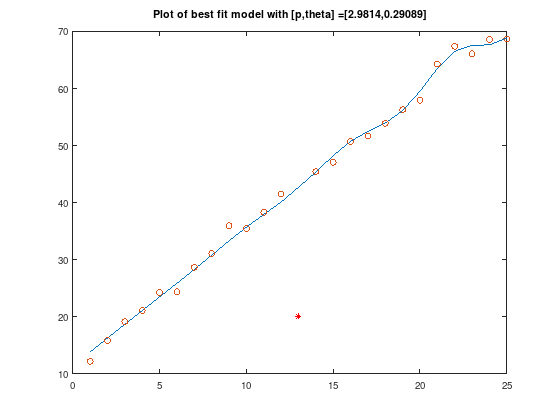

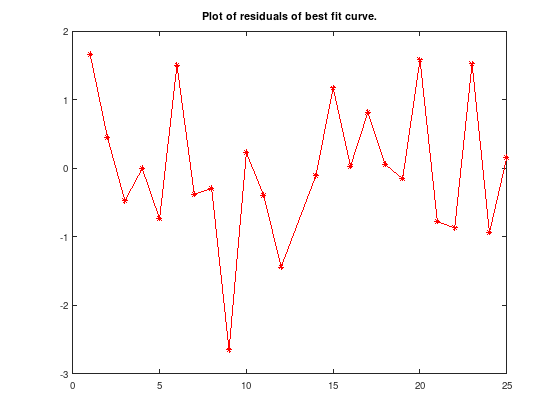

In [7]:
w = fminsearch(@my_model_fn,[1/2,0],[],t,y);

p = w(1);
theta = w(2);

[r2, residuals2, beta2] = my_model_fn(w,t,y);
figure(3)
plot(t,residuals2,'r*-');
title('Plot of residuals of best fit curve.')
figure(4)
A_new = [ones(length(t),1) t' (t').^p.*cos(t'+ theta)];
line2 = A_new*beta2;
plot(t,line2,'-', t, y, 'o', 13, 20.0508 , 'r*');
title(strcat('Plot of best fit model with [p,theta] =[',num2str(p),',',num2str(theta),']'));

In [8]:
mu=mean(y);
cor1 = 1-sum(residuals.^2)/sum((y-mu).^2);
cor2 = 1-sum(residuals_new.^2)/sum((y-mu).^2);
cor3 = 1-sum(residuals2.^2)/sum((y-mu).^2);

disp("first model");
disp(cor1)
disp("second model")
disp(cor2)
disp("third model")
disp(cor3)

first model
0.9941
second model
0.9962
third model
0.9967


### Plot the residuals per independent variable ($ p $, $ \theta $)

The function fminsearch uses the Nelder-Mead method.

To visualise the search, imagine that 

$ p = x $

$ \theta = y $

$ residuals = z $

In a typical three-dimensional descent.

Then for plotting, let $ x, y, z $ be the space.

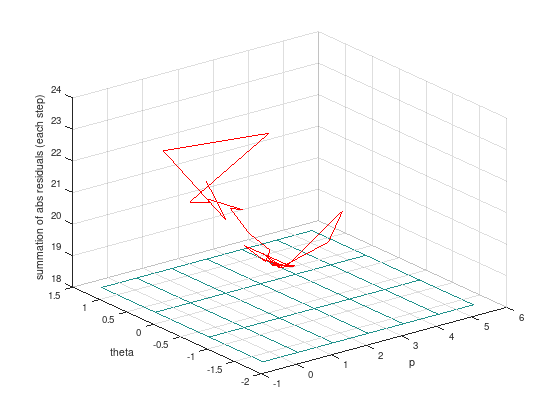

In [9]:
p = wPath(:,1);
theta = wPath(:,2);

plotBuffer = 1;

pMin = min(p) - plotBuffer;
pMax = max(p) + plotBuffer;
thetaMin = min(theta) - plotBuffer;
thetaMax = max(theta) + plotBuffer;


[pSpace, thetaSpace] = meshgrid(pMin:1:pMax, thetaMin:1:thetaMax);
z = pSpace * 0 + 18; # This sets the lower bound for z. 

mesh(pSpace, thetaSpace, z); # helpful to display the plot as a grid space
hold on;
plot3(p, theta, totalResidual, "r-");
xlabel("p");
ylabel("theta");
zlabel("summation of abs residuals (each step)");